# Visualizing Sorting Algorithms

Sorting algorithms vary, for example, in their time and space complexity.
From an artistic viewpoint, they also vary in the way they transiently reposition the elements of the array as the algorithm progresses.
Here, we will animate this transient behavior.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

## Implement sorting algorithms

Each sorting function will be implemented as a generator.
This way, each algorithm will track its state implicitly and the resolution can be adjusted freely by positioning the `yield` calls.
In addition, the raw data is mutable and will be passed by reference. Thus no unnecessary copies are made.

In [2]:
def bubblesort(array):
    n = len(array)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]

            yield array

In [3]:
def insertionsort(array):
    for i in range(1, len(array)):
        key = array[i]

        j = i - 1
        while j >= 0 and key < array[j]:
            array[j + 1] = array[j]
            j -= 1

            yield array

        array[j + 1] = key

        yield array

In [4]:
def selectionsort(array):
    n = len(array)
    for i in range(n):
        min_idx = i
        for j in range(i + 1, n):
            if array[min_idx] > array[j]:
                min_idx = j

            yield array

        array[i], array[min_idx] = array[min_idx], array[i]

        yield array

In [5]:
def cocktailsort(array):
    n = len(array)
    swapped = True
    start = 0
    end = n - 1
    while swapped:
        swapped = False

        for i in range(start, end):
            if array[i] > array[i + 1]:
                array[i], array[i + 1] = array[i + 1], array[i]
                swapped = True

            yield array

        if not swapped:
            break

        swapped = False
        end = end - 1

        for i in range(end - 1, start - 1, -1):
            if array[i] > array[i + 1]:
                array[i], array[i + 1] = array[i + 1], array[i]
                swapped = True

            yield array

        start = start + 1

        yield array

In [6]:
def partition(array, low, high):
    i = low - 1
    pivot = array[high]

    array_list = []
    for j in range(low, high):
        if array[j] < pivot:
            i = i + 1
            array[i], array[j] = array[j], array[i]

        array_list.append(array.copy())

    array[i + 1], array[high] = array[high], array[i + 1]
    array_list.append(array.copy())

    return i + 1, array_list


def quicksort(array, low=0, high=None):
    if high is None:
        high = len(array) - 1

    if low < high:
        pi, array_list = partition(array, low, high)
        yield from array_list

        yield from quicksort(array, low, pi - 1)
        yield from quicksort(array, pi + 1, high)

        yield array

In [7]:
def mergesort(array, left_index=0, right_index=None):
    if right_index is None:
        right_index = len(array) - 1

    if left_index >= right_index:
        return

    mid = (left_index + right_index) // 2
    yield from mergesort(array, left_index=left_index, right_index=mid)
    yield from mergesort(array, left_index=mid + 1, right_index=right_index)

    left_copy = array[left_index : mid + 1].copy()
    right_copy = array[mid + 1 : right_index + 1].copy()

    left_copy_index = 0
    right_copy_index = 0
    sorted_index = left_index

    while left_copy_index < len(left_copy) and right_copy_index < len(right_copy):
        if left_copy[left_copy_index] <= right_copy[right_copy_index]:
            array[sorted_index] = left_copy[left_copy_index]
            left_copy_index = left_copy_index + 1
        else:
            array[sorted_index] = right_copy[right_copy_index]
            right_copy_index = right_copy_index + 1
        sorted_index = sorted_index + 1

        yield array

    while left_copy_index < len(left_copy):
        array[sorted_index] = left_copy[left_copy_index]
        left_copy_index = left_copy_index + 1
        sorted_index = sorted_index + 1

        yield array

    while right_copy_index < len(right_copy):
        array[sorted_index] = right_copy[right_copy_index]
        right_copy_index = right_copy_index + 1
        sorted_index = sorted_index + 1

        yield array

    yield array

In [8]:
def heapify(array, n, i):
    largest = i
    l = 2 * i + 1
    r = 2 * i + 2

    if l < n and array[largest] < array[l]:
        largest = l
    if r < n and array[largest] < array[r]:
        largest = r

    if largest != i:
        array[i], array[largest] = array[largest], array[i]
        yield array

        yield from heapify(array, n, largest)


def heapsort(array):
    n = len(array)

    for i in range(n // 2 - 1, -1, -1):
        yield from heapify(array, n, i)

        yield array

    for i in range(n - 1, 0, -1):
        array[i], array[0] = array[0], array[i]
        yield from heapify(array, i, 0)

        yield array

In [9]:
def shellsort(array):
    n = len(array)
    gap = n // 2

    while gap > 0:
        for i in range(gap, n):
            temp = array[i]

            j = i
            while j >= gap and array[j - gap] > temp:
                array[j] = array[j - gap]
                j -= gap

                yield array

            array[j] = temp

            yield array
        gap //= 2

In [10]:
def stoogesort(array, low=0, high=None):
    if high is None:
        high = len(array) - 1

    if low >= high:
        return

    if array[low] > array[high]:
        array[low], array[high] = array[high], array[low]

    yield array

    if high - low + 1 > 2:
        sep = (high - low + 1) // 3

        yield from stoogesort(array, low, high - sep)
        yield from stoogesort(array, low + sep, high)
        yield from stoogesort(array, low, high - sep)

    yield array

In [11]:
def combsort(array):
    n = len(array)
    shrink_factor = 1.3
    _gap = n
    sorted_ = False

    while not sorted_:
        _gap /= shrink_factor
        gap = int(_gap)

        if gap <= 1:
            sorted_ = True
            gap = 1

        for i in range(n - gap):
            if array[i] > array[i + gap]:
                array[i], array[i + gap] = array[i + gap], array[i]
                sorted_ = False

            yield array

In [12]:
algorithm_list = [
    bubblesort,
    cocktailsort,
    combsort,
    heapsort,
    insertionsort,
    mergesort,
    quicksort,
    selectionsort,
    shellsort,
    # stoogesort,  # takes a long time
]

## Try out one of the algorithms

Let's see how each generator yields intermediate arrays until it finally sorts it completely.

In [13]:
array = np.arange(4)[::-1]

print('Initial array:', array)
for i, arr in enumerate(bubblesort(array)):
    print(f'At iteration {i}:', arr)
print('Final array:', array)

Initial array: [3 2 1 0]
At iteration 0: [2 3 1 0]
At iteration 1: [2 1 3 0]
At iteration 2: [2 1 0 3]
At iteration 3: [1 2 0 3]
At iteration 4: [1 0 2 3]
At iteration 5: [0 1 2 3]
Final array: [0 1 2 3]


## Create animations

The `animate` function is straight-forward, it simply updates the data in each plot.
The data is updated in the `step` function.
Here, a generator is created for each sorting instance (row of each data block) and then executed until all generators are exhausted.

In [14]:
def animate(data_list, im_list):
    """Put each data block in appropriate image."""
    for data, im in zip(data_list, im_list):
        im.set_data(data)
    return im_list


def step():
    """Run algorithms."""
    # initialize sorting functions
    generator_list = [
        sort_function(row)
        for block, sort_function in zip(data_list, algorithm_list)
        for row in block
    ]

    while True:
        has_stopped = 0
        for gen in generator_list:
            try:
                # advance each sorting algorithm by one step
                next(gen)
            except StopIteration:
                has_stopped += 1

        if len(generator_list) == has_stopped:
            # all lists are sorted when all generators are exhausted
            break

        # yield intermediate result for plotting of animation frame
        yield data_list


def create_animation(array_length, repetition_num, max_iter_num=50_000, block_size=3):
    # TODO: get rid of evil global variables
    global data_list

    # generate unsorted data
    block = np.repeat([np.arange(array_length).astype(float)], repetition_num, axis=0)
    [np.random.shuffle(row) for row in block]

    data_list = [block.copy() for _ in algorithm_list]

    # setup figure
    size = np.ceil(np.sqrt(len(algorithm_list))).astype(int)

    fig, ax_grid = plt.subplots(
        nrows=size,
        ncols=size,
        figsize=(size * block_size, size * block_size),
        constrained_layout=True,
    )
    ax_list = ax_grid.ravel()

    im_list = [
        ax.imshow(data, interpolation='nearest') for ax, data in zip(ax_list, data_list)
    ]
    [ax.axis('off') for ax in ax_list]
    [ax.set_title(alg.__name__) for ax, alg in zip(ax_list, algorithm_list)]

    # create animation
    return animation.FuncAnimation(
        fig=fig,
        func=animate,
        frames=step,  # init_func=init_func,  # TODO: use init_func to start with appropriate frame
        save_count=max_iter_num,
        interval=10,
        repeat=True,
        fargs=(im_list,),
        blit=True,
    )

CPU times: user 6.16 s, sys: 232 ms, total: 6.39 s
Wall time: 6.17 s


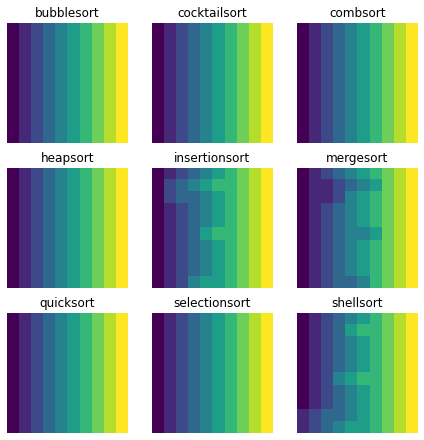

In [15]:
%%time
small_animation = create_animation(10, 10, block_size=2)
HTML(small_animation.to_jshtml(default_mode=None))

CPU times: user 17min 41s, sys: 2min 4s, total: 19min 46s
Wall time: 6min 48s


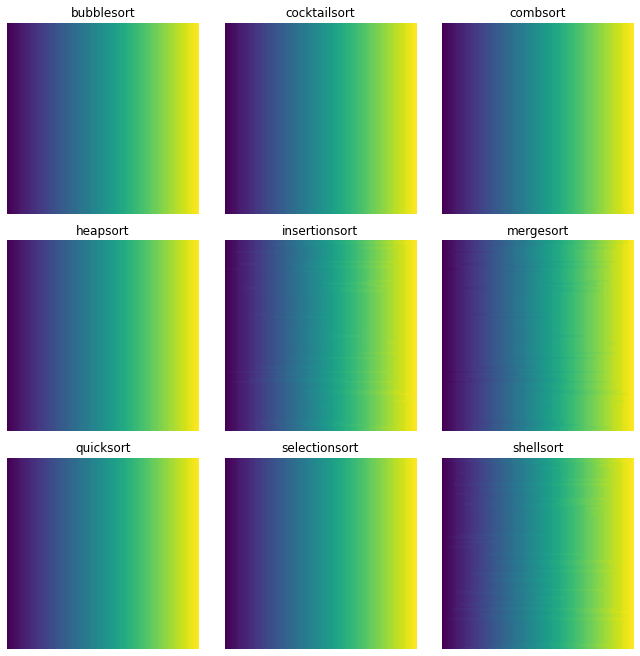

In [16]:
%%time
big_animation = create_animation(80, 80)
HTML(big_animation.to_html5_video())